https://www.kaggle.com/code/uzzivirus/age-and-gender-detection

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


import os,cv2
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR = 'utkface_aligned_cropped/crop_part1'


1_0_0239389.JPG image means that age is 1, gender is 0 (male) 

In [10]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/9780 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
gender_dict = {0:'Male', 1:'Female'}
df.head()

,image,age,gender
0,utkface_aligned_cropped/crop_part1\100_1_0_201...,100,1
1,utkface_aligned_cropped/crop_part1\100_1_2_201...,100,1
2,utkface_aligned_cropped/crop_part1\101_1_2_201...,101,1
3,utkface_aligned_cropped/crop_part1\10_0_0_2016...,10,0
4,utkface_aligned_cropped/crop_part1\10_0_0_2017...,10,0


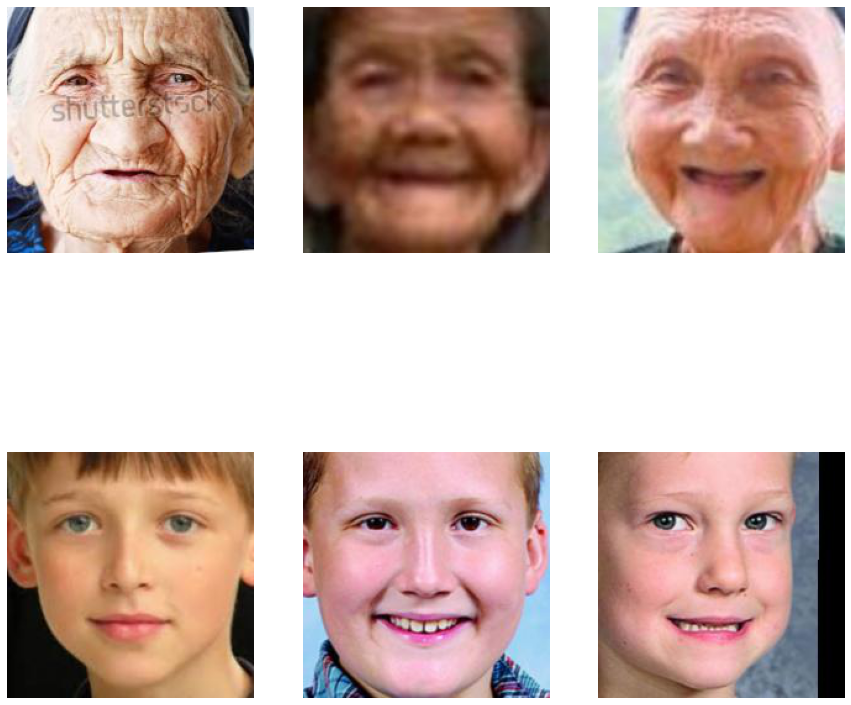

In [12]:
plt.figure(figsize=(15,15))
# Determine the number of rows needed to display all images
n_images = 6
n_rows = (n_images + 2) // 3

for i in range(n_images):
    img = Image.open(df['image'][i])
    plt.subplot(n_rows, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

 

In [13]:
df.gender.value_counts()

1    5407
0    4372
3       1
Name: gender, dtype: int64

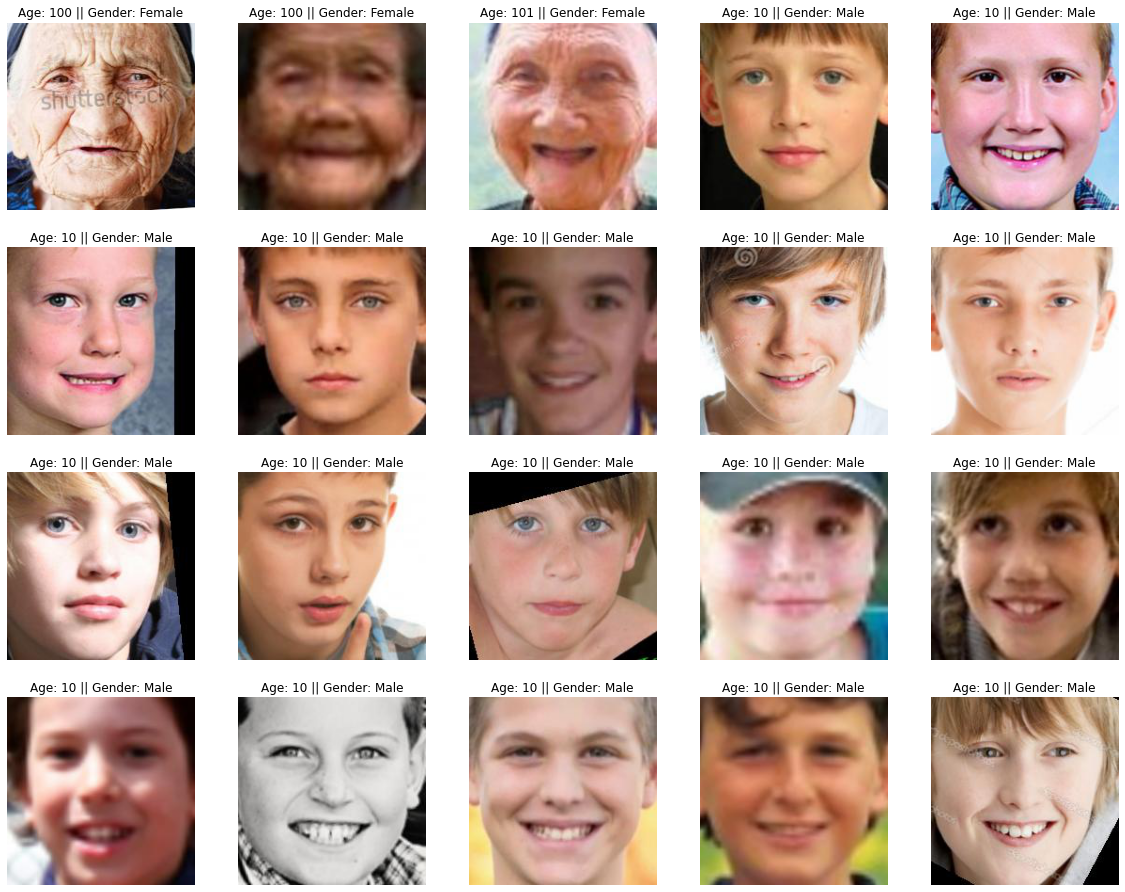

In [14]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:20]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = Image.open(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} || Gender: {gender_dict[gender]}")
    plt.axis('off')

In [15]:
from keras.utils import np_utils
def extract_features(images):
    features = []
    
    for image in tqdm(images):
        img = tf.keras.utils.load_img(image, grayscale=True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
#         one_hot = np_utils.to_categorical(img)
#         one_hot_image.append(one_hot)

        
    features = np.array(features)
#     one_hot_image = np.array(one_hot_image)
    return features

In [16]:
X = extract_features(df['image'])
X.shape

  0%|          | 0/9780 [00:00<?, ?it/s]

(9780, 128, 128)

In [17]:
# one_hot = np_utils.to_categorical(X)


In [18]:
X = X/255.0


In [ ]:
import pickle 
with open('data.pkl','wb') as f:
      pickle.dump(X, f)

  

In [ ]:
import pickle 
with open('data.pkl','rb') as f:
      X = pickle.load(f)

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
inputs = (128,128, 1)
y_age

In [ ]:
df

In [19]:
def age_labels(age):
    if 1<=age<=2:
        return 0
    elif 3<= age <=9:
        return 1
    elif 10<= age <=20:
        return 2
    elif 21<= age <=27:
        return 3
    elif 28<= age <=45:
        return 4
    elif 46<= age <=66:
        return 5
    else:
        return 6
df['target'] =df['age'].map( age_labels)
df['target'] = df['age'].map( age_labels)
df['target'].value_counts(normalize=True)
# df['target'].value_counts(normalize=True)
target=np.array(df['target'])

In [21]:
np.unique(target)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [22]:
y = tf.keras.utils.to_categorical(target)


In [24]:


# Define the input shape
input_shape = (128, 128, 1)

# Create the input layer
inputs = Input(shape=input_shape)

# Add the Flatten layer
flatten = Flatten()(inputs)

# Add the first Conv2D layer
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Add the second Conv2D layer
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout1 = Dropout(0.3)(pool2)

# Add the third Conv2D layer
conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout1)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout2 = Dropout(0.3)(pool3)

# Add the fourth Conv2D layer
conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout2)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Flatten the output of the fourth Conv2D layer
flatten2 = Flatten()(pool4)

# Add the fully connected layers
dense1 = Dense(256, activation='relu')(flatten2)
dropout3 = Dropout(0.5)(dense1)
output = Dense(7, activation='softmax', name='age_output')(dropout3)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [25]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# training process will be stopped if the monitored quantity does not improve for 10 consecutive epochs.
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(X, y, random_state=42)

model.fit(x=x_train_age,y=y_train_age ,callbacks=[early_stopping], batch_size=400, epochs=8, validation_split=0.2)

Epoch 1/8
15/15 [==============================] - 98s 6s/step - loss: 1.9599 - accuracy: 0.1667 - val_loss: 1.9307 - val_accuracy: 0.1554
Epoch 2/8
15/15 [==============================] - 91s 6s/step - loss: 1.9257 - accuracy: 0.1752 - val_loss: 1.9263 - val_accuracy: 0.2679
Epoch 3/8
15/15 [==============================] - 90s 6s/step - loss: 1.8990 - accuracy: 0.2192 - val_loss: 1.8600 - val_accuracy: 0.2870
Epoch 4/8
15/15 [==============================] - 90s 6s/step - loss: 1.7922 - accuracy: 0.2788 - val_loss: 1.7026 - val_accuracy: 0.3361
Epoch 5/8
15/15 [==============================] - 90s 6s/step - loss: 1.6201 - accuracy: 0.3480 - val_loss: 1.4852 - val_accuracy: 0.4035
Epoch 6/8
15/15 [==============================] - 90s 6s/step - loss: 1.4669 - accuracy: 0.3983 - val_loss: 1.3722 - val_accuracy: 0.4731
Epoch 7/8
15/15 [==============================] - 421s 30s/step - loss: 1.3862 - accuracy: 0.4300 - val_loss: 1.3271 - val_accuracy: 0.4649
Epoch 8/8
15/15 [========

sparse_categorical_crossentropy is a loss function that can be used instead of categorical_crossentropy in situations where your labels are integers instead of one-hot encoded vectors. It computes the same loss as categorical_crossentropy, but it accepts integer labels as inputs instead of one-hot encoded vectors.

In [ ]:
 model.save('Agemodel.h5')
# # checkpoint = ModelCheckpoint(filepath="final_cnn_model.h5",
# #                              monitor='val_accuracy',
# #                              save_best_only=True,
# #                              save_weights_only=False,
# #                              verbose=1
# #                             )

In [4]:
model2 = load_model('Agemodel.h5')


NameError: name 'load_model' is not defined

In [5]:
# image = cv2.imread()
# image = Image.fromarray(image, 'RGB')
# image = image.resize((64, 64))
# image=np.array(image)
ranges = ['1-2','3-9','10-20','21-27','28-45','46-65','66-116']

img = tf.keras.utils.load_img("UTKFace/27_1_0_20170109002819172.jpg.chip.jpg", grayscale=True)
img2= tf.keras.utils.load_img("b.jpeg", grayscale=True)

# image = cv2.imread("UTKFace\9_1_0_20170105000600802.jpg.chip.jpg")
img = img.resize((128,128), Image.ANTIALIAS)
img = np.array(img)
input_shape = (128, 128, 1)
pred=model2.predict(img.reshape(1, 128, 128, 1))
# pred_gender = gender_dict[round(pred[0][0][0])]
pred_age=np.argmax(pred)
# print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(img.reshape(128, 128), cmap='gray');

d=ranges[pred_age]
d

NameError: name 'tf' is not defined

In [ ]:
y_prob=model2.predict(x_test_age)
y_pred=tf.keras.utils.to_categorical(y_prob.argmax(axis=1))

In [ ]:
y_pred[11],y_test_age[11]

In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test_age)

In [ ]:
history = gender_model.fit(x=X, y=y_gender, batch_size=32, epochs=10, validation_split=0.2)


In [ ]:
pred